In [95]:
import numpy as np
import pandas as pd
from IPython.display import display
import random
import math
import os 
import sys

import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [96]:
implicit_num_threads = 12
os.environ["OMP_NUM_THREADS"] = str(implicit_num_threads)
os.environ["MKL_NUM_THREADS"] = str(implicit_num_threads)
os.environ["OPENBLAS_NUM_THREADS"] = str(implicit_num_threads)

In [97]:
class gomoku_game:
    def __init__(self):
        self.dim = 15 #15x15 board, can be 19x19
        self.state = np.zeros([self.dim, self.dim], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2} 
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'loss': -1}
        self.available = [] #initialize to all spots on board
        for i in range(self.dim):
            for j in range(self.dim):
                self.available.append(i + j* self.dim)
    
    def render(self): #rev
        rendered_board_state = self.state.copy().astype(str)
        rendered_board_state[self.state == 0] = ' '
        rendered_board_state[self.state == 1] = 'B'
        rendered_board_state[self.state == 2] = 'W'
        display(pd.DataFrame(rendered_board_state))
    
    def reset(self): #rev
        self.__init__()
        
    def get_available_actions(self):
        return self.available
    

    def check_game_done(self, player, last):
        def check_flat(state, i, j):
            ci = i
            while ci > 0 and state[ci][j] == state[i][j]: 
                ci -= 1
            if state[ci][j] != state[i][j]:
                left = ci + 1
            else:
                left = ci
            ri = i
            while ri < (len(state) - 1) and state[ri][j] == state[i][j]: 
                ri += 1 
            if state[ri][j] != state[i][j]:
                right = ri - 1
            else:
                right = ri
            if right - left >= 4: 
                return True 
            return False

        '''
        find length of current diag with equal values and if over 4 return true 
        '''
        def check_diag(state, i, j):
            li = i
            lj = j
            while li > 0 and lj > 0 and state[li][lj] == state[i][j]:
                li -= 1
                lj -= 1
            if state[li][lj] != state[i][j]:
                lowi = li + 1
                lowj = lj + 1
            else:
                lowi = li
                lowj = lj

            ui = i
            uj = j
            while ui < len(state) - 1 and uj < len(state) - 1 and state[ui][uj] == state[i][j]:
                ui += 1
                uj += 1
            if state[ui][uj] != state[i][j]:
                upi = ui - 1
                upj = uj - 1
            else:
                upi = ui
                upj = uj

            if upi - lowi >= 4: 
                return True
            return False

        '''
        input:
            state: board state (15x15 numpy array)
        output:
            win: boolean value of whether current player won
        '''
        
        #check diagonal
        #check horizontal
        #check vertical
        i, j = last
        # stateCp = self.state.copy()

        vert = check_flat(self.state, i, j)  #I dont believe these need to be copied
        horiz = check_flat(self.state.T, j, i)
        
        # print("hor" + str(horiz))
        # print("vert" + str(vert))
        
        #i think this should work??
        diagl = check_diag(self.state, i, j)
        diagr = check_diag(np.fliplr(self.state), i, len(self.state) -1 - j)

        diag = diagl or diagr

        return (horiz or vert) or diag


    def make_move(self, a, player):
        # check if move is valid
        i = a % self.dim
        j = int((a - i)/ self.dim)
        openSpots = self.get_available_actions()
        if a in openSpots:
            self.state[i,j] = self.players[player]
            self.available.remove(a)
        else:
            print('Move is invalid')
            self.render()
        a = (i, j)
        win = self.check_game_done(player, a)

        reward = 0.
        if len(openSpots) == 0:
            reward = self.reward['draw']
            self.isDone = True
        elif win:  
            reward = self.reward['win']
            self.isDone = True

        # give feedback as new state and reward
        # return self.state.copy(), reward
        return self.state, reward

env = gomoku_game()

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


In [99]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


#***based on torch tutorial
class ReplayMemory(object):

    def __init__(self):
        self.memory = deque([])

    #could use *args for historical turns? 
    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
memory = ReplayMemory()

In [100]:
class DQN(nn.Module):
    
    def __init__(self, outputs):
        super(DQN, self).__init__()
        # 6 by 7, 10 by 11 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(7,7), padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(7,7), padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(7,7), padding=2)
        # self.conv4 = nn.Conv2d(128, 128, kernel_size=4, padding=2)
        # self.conv5 = nn.Conv2d(128, 64, kernel_size=4, padding=2)
        # self.conv6 = nn.Conv2d(64, 32, kernel_size=4, padding=2)
        # self.conv7 = nn.Conv2d(32, 32, kernel_size=4, padding=2)

        # linear_input_size = 6 * 7 * 32
        self.MLP1 = nn.Linear(2592, 1024)
        self.MLP2 = nn.Linear(1024, 1024)
        # self.MLP3 = nn.Linear(50, 50)
        self.MLP4 = nn.Linear(1024, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        # x = F.leaky_relu(self.conv4(x))
        # x = F.leaky_relu(self.conv5(x))
        # x = F.leaky_relu(self.conv6(x))
        # x = F.leaky_relu(self.conv7(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        x = F.leaky_relu(self.MLP2(x))
        # x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)
    

# def DQN (outputs):
#     model = nn.Sequential(
#         nn.Conv2d(1, 32, kernel_size=(7,7), padding=2), 
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         nn.Conv2d(32, 32, kernel_size=(7,7), padding=2),
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         # nn.MaxPool2d((2,2)),
#         nn.Conv2d(32, 64, kernel_size=(7,7), padding=2),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         # nn.MaxPool2d((2,2)),
#         nn.Flatten(),
#         nn.Linear(5184, 1024),
#         nn.ReLU(),
#         nn.Linear(1024, outputs),
#     )
#     return model

In [101]:
#params
B = 256 #batch size
gamma = 0.99 #0.999 or 0.9999 or decrease?
lr = 1e-4
eps_start = 0.9
eps_end = 0.05
eps_decay = 2000
tau = 0.005

bSize = env.dim #board dimensions
n_actions = bSize **2


policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())


# target_net.eval() # set target net into eval mode
optimizer = optim.Adam(policy_net.parameters(), lr=lr)

#STEPS DONE - Maybe isolate this variable so dont always need to reset eps?
steps_done = 0
training_history = []

def select_action(state, available_actions, training=True):
    current_chance = random.random()
    
    #available_actions = state.get_available_actions()
    if training:
        global steps_done
        eps_threshold = eps_start + (eps_start - eps_end) * math.exp(-1 * steps_done / eps_decay)
    else:
        eps_threshold = 0

    if current_chance > eps_threshold:
        with torch.no_grad():
            all_probabilities = policy_net(torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0))[0, :] #unsqez
            potential_action_probs = [all_probabilities[a] for a in available_actions]
            return available_actions[np.argmax(potential_action_probs)] #Always pick most likely - could use an additional layer of randomness for fun tho?
    else: 
        return random.choice(available_actions)
    



#episode_duration = []

#def plot duractions -> slow


In [137]:
#Optimization of model 

def optimize_model():
    if len(memory) < B:
        return

    transitions = memory.sample(B)
    batch = Transition(*zip(*transitions))

    # state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
    #                                     [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])
    # print(batch.state)
    # alt_state = np.array((len(batch.state), 15, 15))
    # for i, v in enumerate(batch.state):
    #     print(type(v))
    #     alt_state[i]= v


    state_batch = torch.from_numpy(np.asarray(batch.state, dtype=np.float32))
    action_batch = torch.from_numpy(np.asarray(batch.action, dtype=np.int64))
    reward_batch = torch.from_numpy(np.asarray(batch.reward, dtype=np.float32))



    # state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    # action_batch = torch.tensor(batch.action, dtype=torch.long, device=device)
    # reward_batch = torch.tensor(batch.reward, dtype=torch.float, device=device)

    # print(len(state_batch))
    # print(type(state_batch))
    # state_batch = torch.from_numpy(state_batch)
    # action_batch = torch.from_numpy(action_batch)
    # reward_batch = torch.from_numpy(reward_batch)

    # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
    #                                       batch.next_state)), device=device)
    # non_final_next_states = torch.cat([torch.tensor(s, dtype=torch.float, device=device).unsqueeze(0) for s in batch.next_state
    #                                             if s is not None])
    
    # non_final_next_state = torch.cat([torch.tensor(s_, dtype=torch.float, device=device).unsqueeze(0) for s_ in next_state_batch if s_[0] is not None])



    # state_batch = torch.cat(torch.from_numpy((batch.state)[0]))
    # action_batch = torch.cat(batch.action)
    # reward_batch = torch.cat(batch.reward)


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device)
    non_final_next_states = torch.cat([torch.tensor(s_, dtype=torch.float, device=device).unsqueeze(0) for s_ in batch.next_state if s_ is not None])

    # print(.shape)
    state_action_values = policy_net(state_batch.unsqueeze(1)).gather(1, action_batch.unsqueeze(1))

    next_state_values = torch.zeros(B, device=device)
    
    next_state_values[non_final_mask] = target_net(non_final_next_states.unsqueeze(1)).max(1)[0].detach()
    # compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    




In [138]:
# random agent
def random_agent(actions):
    return random.choice(actions)

# win rate test
def win_rate_test():
    EVAL_EPOCHS = 100
    win_moves_taken_list = []
    win = []
    for i in range(EVAL_EPOCHS):
        env.reset()
        win_moves_taken = 0
        # state = env.state.copy()
        while not env.isDone:
            
            available_actions = env.get_available_actions()
            action = select_action(state, available_actions, training=False)
            state, reward = env.make_move(action, 'p1')
            win_moves_taken += 1

            if reward == 1:
                win_moves_taken_list.append(win_moves_taken)
                win.append(1)
                break

            available_actions = env.get_available_actions()
            action = random_agent(available_actions)
            state, reward = env.make_move(action, 'p2')

    return sum(win)/EVAL_EPOCHS, sum(win_moves_taken_list)/len(win_moves_taken_list)

In [139]:
from itertools import count

num_episodes = 200
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 10

for i in range(num_episodes): 
    env.reset()
    state_p1 = env.state.copy()
    print(i)
    # record every 20 epochs
    # print(i)
    if i % 10 == 9:
        win_rate, moves_taken = win_rate_test()
        training_history.append([i + 1, win_rate, moves_taken])
        # th = np.array(training_history)
        # print training message every 200 epochs
        if i % 20 == 19:
            print('Episode {}: | win_rate: {} | moves_taken: {}'.format(i, training_history[-1][1], training_history[-1][2]))

    for t in count():
        available_actions = env.get_available_actions()
        action_p1 = select_action(state_p1, available_actions, steps_done)
        steps_done += 1
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')
        
        if env.isDone:
            if reward_p1 == 1:
                # reward p1 for p1's win
                memory.push(state_p1, action_p1, 1, None)
            else:
                # state action value tuple for a draw
                memory.push(state_p1, action_p1, 0.5, None)
            break
        
        available_actions = env.get_available_actions()
        action_p2 = random_agent(available_actions)
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')
        
        if env.isDone:
            if reward_p2 == 1:
                # punish p1 for (random agent) p2's win 
                memory.push(state_p1, action_p1, -1, None)
            else:
                # state action value tuple for a draw
                memory.push(state_p1, action_p1, 0.5, None)
            break
        
        # punish for taking too long to win
        memory.push(state_p1, action_p1, -0.05, state_p2_)
        state_p1 = state_p2_
        
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

0
1
2
3
4
5
6
7
8
9


UnboundLocalError: local variable 'state' referenced before assignment

In [74]:
path = 'gomo-test-output.pth'
torch.save(policy_net.state_dict(), path)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

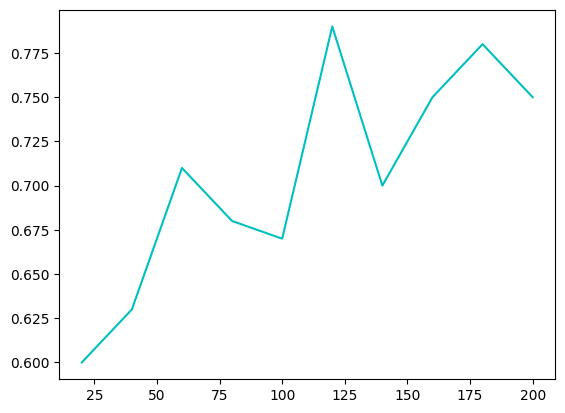

In [75]:
plt.plot(th[:, 0], th[:, 1], c='c')
win_rate_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 1])] for i in range(len(th) - 19)])
plt.plot(win_rate_moving_average[:, 0], win_rate_moving_average[:, 1], c='b', label='moving average of win rate')
plt.legend()
plt.title('Playing against random agent')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(th[:, 0], th[:, 2], c='c')
win_steps_taken_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 2])] for i in range(len(th) - 19)])
plt.plot(win_steps_taken_moving_average[:, 0], win_steps_taken_moving_average[:, 1], c='b', label='moving average of win steps taken')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()

In [91]:
def demo():
    env.reset()
    env.render()
    ind = 0
    turnRef = ['p1', 'p2']
    state = env.state.copy()
    while not env.isDone:
        available_actions = env.get_available_actions()
        action = select_action(state, available_actions, training=False)
        # trained agent's move is denoted by O
        state, reward = env.make_move(action, turnRef[ind])
        ind+=1
        env.render()

        if reward == 1:
            print('p1')
            break
        
        available_actions = env.get_available_actions()
        action = random_agent(available_actions)
        # action = select_action(state, available_actions, training=False)
        state, reward = env.make_move(action, turnRef[ind])
        ind-=1
        env.render()
        if reward == 1:
            print('p2')
            break


demo()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,B,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,,,,W,,,B,,,
8,,,,,,,W,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,,,W,,
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,,W,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,,W,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,W,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,W,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,W,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,W,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,W,,,,,B,,B,W,,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,B,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,,,,,,W,W,,,,,,,
9,,,,,,,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,B,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,,W,,,,W,W,,,,,,,
9,,,,,,,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,B,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,,,,,,,,
6,,W,W,,,,,B,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,,,B,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,,B,B,,,,,,
7,W,,,,,B,,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,W,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,,,,W,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,,,,B,,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,W,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,B,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,W,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,B,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,,B,,,,,
9,,,,,,B,W,,B,W,B,,,W,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,B,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,B,B,,,,,
9,,,,,,B,W,,B,W,B,,,W,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,B,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,B,B,,,,,
9,,,,,,B,W,,B,W,B,,,W,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,,,,,,
7,W,B,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,B,B,,,,,
9,,,,,,B,W,,B,W,B,,,W,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,W,,,,,,,,,,,,W,W
1,,,,,W,,,W,B,,B,,W,,B
2,,,,,,W,,,,W,,,W,,B
3,B,W,B,,,,,B,,,,,,W,
4,W,B,,,,,,,B,B,B,,,,
5,,,,,W,,,B,B,,W,,,,
6,W,W,W,,,W,W,B,B,W,,,,,
7,W,B,,,,B,B,B,W,B,,B,,,
8,B,W,W,,,,W,W,B,B,,,,,
9,,,,,,B,W,,B,W,B,,,W,


p2
